In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm
import statistics 
from sklearn.preprocessing import StandardScaler
import random

In [2]:
fix_seed = 1111
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [3]:
df=pd.read_csv("D:/Transformer_thesis/Dataset/V_228.csv",header=None)
df_know=pd.read_csv("D:/Transformer_thesis/Dataset/final_knowledge/final/traffic/horizon_9/t_preds.csv", header=None)




In [4]:
df=df.iloc[:,:5]
df_know=df_know.iloc[:,:5]

In [5]:
df.shape,df_know.shape

((12672, 5), (12660, 5))

In [6]:
#data=df.iloc[:,:5].values

In [7]:
data=df.values

In [8]:
def train_test_split(data):
   
   test_size=1440
   validation_size=1440
   train_data=data[:-test_size - validation_size]
   
   validation_data=data[-test_size - validation_size-12:-test_size]
   test_data=data[-test_size-12:]
   return train_data,validation_data,test_data

In [9]:
def train_test_split_know(data):
   
   test_size=1440
   validation_size=1440
   train_data=data[:-test_size - validation_size]

   validation_data=data[-test_size - validation_size:-test_size]
   test_data=data[-test_size:]
   return train_data,validation_data,test_data

In [10]:
def create_train_sequences(data,window_size,forecast_horizon):
  #X=[]
  #y=[]
  X_shape=[(len(data)-window_size-forecast_horizon + 1),window_size]

  y_shape=[(len(data)-window_size-forecast_horizon + 1),forecast_horizon]
  X=np.zeros(X_shape)
  y=np.zeros(y_shape)
  for i in range(len(data)-window_size- forecast_horizon + 1):
        _x = data[i:(i+window_size)]
        #_y = data[i+window_size]
        _y=data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y


  return X,y

In [11]:
def create_test_sequences(data, window_size, forecast_horizon):
    #print(f"data shape:{data.shape} type:{type(data)}")
    num_samples = len(data) // (window_size + forecast_horizon)
    X_shape = (num_samples, window_size)
    y_shape = (num_samples, forecast_horizon)
    X = np.zeros(X_shape)
    y = np.zeros(y_shape)
    #print(f"num_samples in test sequences:{num_samples},len(data):{len(data)}, window_size + horizon:{(window_size + horizon)}")
    
    for i in range(num_samples):
        start_index = i * (window_size + forecast_horizon)
        end_index_x = start_index + window_size
        end_index_y = end_index_x + forecast_horizon

        _x = data[start_index:end_index_x]
        _y = data[end_index_x:end_index_y]

        X[i, :] = _x
        y[i, :] = _y

    return X, y

In [12]:
def create_test_seq_new(data, window_size, horizon):
    length=data.shape[0]-window_size
    loop=length//horizon
    extra = length%horizon

    data = np.append(data,np.zeros([horizon-extra]))

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
        
    output=np.zeros([i_val,window_size])
    y=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[i*horizon:(i*horizon)+window_size]
        y[i,:]= data[(i*horizon)+window_size:(i*horizon)+window_size+horizon]
        
    return output.reshape(output.shape[0],window_size), y


In [13]:
def create_test_k_seq_new(data,horizon):
    
    length = data.shape[0]
    loop=length//horizon
    extra = length%horizon
    data_app = np.repeat(data[-1],(horizon-extra))
    data = np.append(data,data_app)    

    if extra ==0:
        i_val = loop
    else:
        i_val=loop+1
    output=np.zeros([i_val,horizon])
    for i in range(i_val):
        output[i:i+1,:]=data[(i*horizon):(i*horizon)+horizon]
    return output.reshape(output.shape[0],horizon)

In [14]:
context_window=120

def create_attention_seq(data,window_size,forecast_horizon,context_window):
  X_attention=[]
  end_index=0
  for i in range(len(data)-window_size- forecast_horizon + 1):
      if end_index < context_window:
         _x=data[0:window_size+i]
         end_index=window_size+i
         zeros_to_add=[0]*(context_window - len(_x))
         _x = pd.concat([ pd.Series(zeros_to_add),_x],ignore_index=True)
      else:
         _x=data[window_size+i-context_window-1:window_size+i-1]
      X_attention.append(_x)
  return X_attention


In [15]:
def create_attention_test_sequences(data, window_size, forecast_horizon,context_window):
   
    X_attention=np.zeros((len(data),context_window))
    
    for i in range(len(test_x)):
        
        if(i<=int(context_window/sequence_length - 2)):       
            subset_x=data[0:i+1]
            X_attention[i]=np.concatenate ((np.zeros( sequence_length*((int(context_window/sequence_length)) - (i+1)) ), subset_x.reshape(-1)))   
        else:
            
            start_index=int(i-((context_window/sequence_length)-1))
            X_attention[i]=data[start_index:i+1].reshape(-1) 
     
    return X_attention

In [16]:
def create_train_knowledge_seq(data,window_size,horizon):
    y_shape=[(len(data)-horizon + 1),horizon]
    y_know=np.zeros(y_shape)
    
    for i in range(len(data)-window_size- horizon + 1):
        
        _y_know=data[i:i+horizon]
        y_know[i,:]=_y_know

    return y_know

In [17]:
def create_test_knowledge_seq(data,window_size,horizon):
    
    num_samples = len(data) // (window_size + horizon)
    y_shape = (num_samples, horizon)
    y_know = np.zeros(y_shape)
    #print(f"num_samples in know sequences:{num_samples},len(data):{len(data)}, window_size + horizon:{(window_size + horizon)} ")
    for i in range(num_samples):
        start_index = i * (horizon)
        
        end_index_y = start_index + horizon
        
        _y_know = data[start_index:end_index_y]
        
        y_know[i, :] = _y_know

    return y_know

In [18]:
"""
def create_test_sequences(data, window_size, forecast_horizon):

    X_shape=[(len(data)-window_size- forecast_horizon + 1),window_size]
    y_shape=[(len(data)-window_size- forecast_horizon + 1),forecast_horizon]
    X=np.zeros(X_shape)
    y=np.zeros(y_shape)
    step_size = window_size + forecast_horizon

    for i in range(0, len(data) - window_size - forecast_horizon + 1, step_size):
        _x = data[i:(i + window_size)]
        _y = data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y

    return X, y
"""

'\ndef create_test_sequences(data, window_size, forecast_horizon):\n\n    X_shape=[(len(data)-window_size- forecast_horizon + 1),window_size]\n    y_shape=[(len(data)-window_size- forecast_horizon + 1),forecast_horizon]\n    X=np.zeros(X_shape)\n    y=np.zeros(y_shape)\n    step_size = window_size + forecast_horizon\n\n    for i in range(0, len(data) - window_size - forecast_horizon + 1, step_size):\n        _x = data[i:(i + window_size)]\n        _y = data[i + window_size:i + window_size + forecast_horizon]\n        X[i,:]=_x\n        y[i,:]=_y\n\n    return X, y\n'

In [19]:
#sc=MinMaxScaler()
#df_scaled=sc.fit_transform(data)

In [20]:
#df_scaled.shape

In [21]:
scaler = StandardScaler()

In [22]:
sequence_length=12
horizon=9
batch_size=32
input_size=1
hidden_size=64
output_size=1
ff_hiddensize=64
mask_flag=None
attn_head=8
start_dec_token_len=6
test_size=1440
validation_size=1440

In [23]:
df.iloc[:,0]

0        71.1
1        68.1
2        68.0
3        68.3
4        68.9
         ... 
12667    70.3
12668    69.9
12669    68.9
12670    69.2
12671    68.6
Name: 0, Length: 12672, dtype: float64

In [24]:

train_seq_x=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , sequence_length ])
train_seq_y=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , horizon])
valid_seq_x=np.zeros([df.shape[1], validation_size-horizon+1  , sequence_length ])
valid_seq_y=np.zeros([df.shape[1], validation_size-horizon+1 , horizon ])
test_seq_x=np.zeros([df.shape[1], test_size // horizon, sequence_length ])
test_seq_y=np.zeros([df.shape[1],  test_size //horizon, horizon])


train_attention_x=np.zeros([df.shape[1], ((len(df)-validation_size-test_size-sequence_length-horizon+1)), context_window])
valid_attention_x=np.zeros([df.shape[1],  validation_size-horizon+1, context_window])
test_attention_x=np.zeros([df.shape[1], test_size // horizon  , context_window])

train_know_seq_y=np.zeros([df_know.shape[1], (len(df_know)-validation_size-test_size-horizon+1) , horizon])
valid_know_seq_y=np.zeros([df_know.shape[1], validation_size-horizon+1 , horizon ])
test_know_seq_y=np.zeros([df_know.shape[1],  test_size // horizon, horizon])
#print(f"test_know_seq_y shape:{test_know_seq_y.shape} , test_seq_y:{test_seq_y.shape}, test_seq_x:{test_seq_x.shape}")

for i in range(df.shape[1]):
  train_data,validation_data,test_data = train_test_split(df.iloc[:,i])
  train_know_data,validation_know_data,test_know_data = train_test_split_know(df_know.iloc[:,i])
  #print(train_data.shape)
  #break

  scaler.fit(train_data.values.reshape(-1, 1))
  train_data_scaled = scaler.transform(train_data.values.reshape(-1, 1))

  scaler.fit(validation_data.values.reshape(-1, 1))
  validation_data_scaled = scaler.transform(validation_data.values.reshape(-1, 1))

  scaler.fit(test_data.values.reshape(-1, 1))
  test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

  scaler.fit(train_know_data.values.reshape(-1,1))
  train_know_scaled=scaler.transform(train_know_data.values.reshape(-1,1))
    
  scaler.fit(validation_know_data.values.reshape(-1,1))
  validation_know_scaled=scaler.transform(validation_know_data.values.reshape(-1,1))
    
  scaler.fit(test_know_data.values.reshape(-1,1))
  test_know_scaled=scaler.transform(test_know_data.values.reshape(-1,1))
    

  train_x,train_y=create_train_sequences(train_data_scaled.reshape(-1),sequence_length,horizon)
  #train_x,train_y=create_train_sequences(train_data,sequence_length,horizon)
  

  train_seq_x[i,:,:]=train_x
  train_seq_y[i,:,:]=train_y

  #train_seq_x.append(train_x)
  #train_seq_y.append(train_y)

  valid_x,valid_y=create_train_sequences(validation_data_scaled.reshape(-1),sequence_length,horizon)
  
  #valid_x,valid_y=create_train_sequences(validation_data,sequence_length,horizon)
  valid_seq_x[i,:,:]=valid_x
  valid_seq_y[i,:,:]=valid_y
  #valid_seq_x.append(valid_x)
  #valid_seq_y.append(valid_y)

  test_x,test_y=create_test_seq_new(test_data_scaled.reshape(-1),sequence_length,horizon)
    
  #test_x,test_y=create_test_sequences(test_data,sequence_length,horizon)
  test_seq_x[i,:,:]=test_x
  test_seq_y[i,:,:]=test_y
  #test_seq_x.append(test_x)
  #test_seq_y.append(test_y)
  
  train_know_seq_y[i,:,:]=create_train_knowledge_seq(train_know_scaled.reshape(-1),sequence_length,horizon) 
  valid_know_seq_y[i,:,:]=create_train_knowledge_seq(validation_know_scaled.reshape(-1),sequence_length,horizon)
  test_know_seq_y[i,:,:]=create_test_k_seq_new(test_know_scaled.reshape(-1),horizon)
    
  train_attention_x[i,:,:]=create_attention_seq(train_data,sequence_length, horizon,context_window)
  valid_attention_x[i,:,:]=create_attention_seq(validation_data,sequence_length, horizon,context_window)
  test_attention_x[i,:,:]=create_attention_test_sequences(test_x,sequence_length, horizon,context_window)
  

C:\Users\soura\AppData\Local\Temp\ipykernel_31016\1732260069.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _x = pd.concat([ pd.Series(zeros_to_add),_x],ignore_index=True)
C:\Users\soura\AppData\Local\Temp\ipykernel_31016\1732260069.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  _x=data[0:window_size+i]
C:\Users\soura\AppData\Local\Temp\ipykernel_31016\1732260069.py:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.il

In [25]:
#train_data.shape,validation_data.shape,test_data.shape

In [26]:
#train_know_data.shape,validation_know_data.shape,test_know_data.shape

In [27]:
#train_seq_x.shape,valid_seq_x.shape,test_seq_x.shape

In [28]:
#train_know_seq_y.shape,valid_know_seq_y.shape,test_know_seq_y.shape

In [29]:
#train_seq_y.shape,valid_seq_y.shape,test_seq_y.shape

In [30]:
X_train=torch.tensor(train_seq_x,dtype=torch.float32)
y_train=torch.tensor(train_seq_y,dtype=torch.float32)
X_valid=torch.tensor(valid_seq_x,dtype=torch.float32)
y_valid=torch.tensor(valid_seq_y,dtype=torch.float32)
X_test=torch.tensor(test_seq_x,dtype=torch.float32)
y_test=torch.tensor(test_seq_y,dtype=torch.float32)

X_train_attention=torch.tensor(train_attention_x,dtype=torch.float32)
X_valid_attention=torch.tensor(valid_attention_x,dtype=torch.float32)
X_test_attention=torch.tensor(test_attention_x,dtype=torch.float32)

y_know_train_seq=torch.tensor(train_know_seq_y,dtype=torch.float32)
y_know_valid_seq=torch.tensor(valid_know_seq_y,dtype=torch.float32)
y_know_test_seq=torch.tensor(test_know_seq_y,dtype=torch.float32)


In [31]:
#train_know_seq_y.shape

In [32]:
#y_train.shape,y_know_train_seq.shape,y_know_test_seq.shape,X_test.shape

In [33]:
X_train=X_train.unsqueeze(-1)
X_train=X_train.view(-1,X_train.size(2),X_train.size(3))

y_train=y_train.unsqueeze(-1)
y_train=y_train.view(-1,y_train.size(2),y_train.size(3))

X_valid=X_valid.unsqueeze(-1)
X_valid=X_valid.view(-1,X_valid.size(2),X_valid.size(3))

y_valid=y_valid.unsqueeze(-1)
y_valid=y_valid.view(-1,y_valid.size(2),y_valid.size(3))

X_test=X_test.unsqueeze(-1)
y_test=y_test.unsqueeze(-1)


X_train_attention=X_train_attention.unsqueeze(-1)
X_train_attention=X_train_attention.view(-1,X_train_attention.size(-2),X_train_attention.size(3))

X_valid_attention=X_valid_attention.unsqueeze(-1)
X_valid_attention=X_valid_attention.view(-1,X_valid_attention.size(-2),X_valid_attention.size(3))

X_test_attention=X_test_attention.unsqueeze(-1)

y_know_train_seq=y_know_train_seq.unsqueeze(-1)
Y_know_train_seq=y_know_train_seq.view(-1,y_know_train_seq.size(2),y_know_train_seq.size(3))

y_know_valid_seq=y_know_valid_seq.unsqueeze(-1)
Y_know_valid_seq=y_know_valid_seq.view(-1,y_know_train_seq.size(2),y_know_train_seq.size(3))

Y_know_test_seq=y_know_test_seq.unsqueeze(-1)


"""
X_test=X_test.unsqueeze(-1)
X_test=X_test.view(-1,X_test.size(2),X_test.size(3))

y_test=y_test.unsqueeze(-1)
y_test=y_test.view(-1,y_test.size(2),y_test.size(3))
"""

'\nX_test=X_test.unsqueeze(-1)\nX_test=X_test.view(-1,X_test.size(2),X_test.size(3))\n\ny_test=y_test.unsqueeze(-1)\ny_test=y_test.view(-1,y_test.size(2),y_test.size(3))\n'

In [34]:
Y_know_train_seq.shape,y_train.shape,X_test.shape,Y_know_test_seq.shape 

(torch.Size([48860, 9, 1]),
 torch.Size([48860, 9, 1]),
 torch.Size([5, 160, 12, 1]),
 torch.Size([5, 160, 9, 1]))

In [35]:
class TimeseriesDataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [36]:
class AttentionDataset(Dataset):
  def __init__(self,X):
    self.X=X
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx]

In [37]:
class KnowledgeDataset(Dataset):
  def __init__(self,X):
    self.X=X
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx]

In [38]:
train_dataset=TimeseriesDataset(X_train,y_train)
valid_dataset=TimeseriesDataset(X_valid,y_valid)
test_dataset=TimeseriesDataset(X_test,y_test)

train_attention_dataset=AttentionDataset(X_train_attention)
valid_attention_dataset=AttentionDataset(X_valid_attention)
test_attention_dataset=AttentionDataset(X_test_attention)

train_know_dataset=KnowledgeDataset(Y_know_train_seq)
valid_know_dataset=KnowledgeDataset(Y_know_valid_seq)
test_know_dataset=KnowledgeDataset(Y_know_test_seq)


In [39]:
train_loader=DataLoader(train_dataset,batch_size,drop_last=True)
valid_loader=DataLoader(valid_dataset,batch_size,drop_last=True)
test_loader=DataLoader(test_dataset,batch_size,drop_last=True)

train_attention_loader=DataLoader(train_attention_dataset,batch_size,drop_last=True)
valid_attention_loader=DataLoader(valid_attention_dataset,batch_size,drop_last=True)
test_attention_loader=DataLoader(test_attention_dataset,batch_size,drop_last=True)

train_knowledge_loader=DataLoader(train_know_dataset,batch_size,drop_last=True)
valid_knowledge_loader=DataLoader(valid_know_dataset,batch_size,drop_last=True)
test_knowledge_loader=DataLoader(test_know_dataset,batch_size,drop_last=True)


In [40]:
class InputEmbedding(nn.Module):
  def __init__(self,input_size,hidden_size):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.conv1d=nn.Conv1d(in_channels=self.input_size,out_channels=self.hidden_size,padding=1,kernel_size=3,bias=False)
  def forward(self,x):
      embedded_inp=self.conv1d(x.permute(0,2,1))
      return embedded_inp.transpose(1,2)


In [41]:
class RelativePositionalEmbedding(nn.Module):
    def __init__(self,head_dim,max_position=512):
        super(RelativePositionalEmbedding,self).__init__()
        self.pos_embed=nn.Parameter(torch.Tensor(max_position * 2 + 1, head_dim))
        nn.init.xavier_uniform_(self.pos_embed)
        self.max_position=max_position
    def forward(self,query_len,key_len):
        query_range=torch.arange(query_len)
        key_range=torch.arange(key_len)
        relative_matrix=key_range[None,:]-query_range[:,None]
        clipped_relative_matrix = torch.clamp(relative_matrix, -self.max_position, self.max_position)
        relative_matrix=clipped_relative_matrix+self.max_position 
        return self.pos_embed[relative_matrix]
        

In [42]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()* -(math.log(10000.0) / d_model)).exp()
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self,x):
        return self.pe[:,:x.size(1)]

In [43]:
class CorrelationAttentionLayer(nn.Module):
  def __init__(self,attn_head,hidden_size):
    super().__init__()
    self.attn_head=attn_head
    self.hidden_size=hidden_size
    self.dropout=nn.Dropout(0.1)

    self.queries_emb=nn.Linear(hidden_size,hidden_size)
    self.keys_emb=nn.Linear(hidden_size,hidden_size)
    self.values_emb=nn.Linear(hidden_size,hidden_size)

  def forward(self,q,k,v,attention_mask,return_attention):
    b,l,d=q.shape
    b,s,d=k.shape

    #Linear projection and creation of multiple heads
    queries=self.queries_emb(q).view(b,l,self.attn_head,-1)
    keys=self.keys_emb(k).view(b,s,self.attn_head,-1)
    values=self.values_emb(v).view(b,s,self.attn_head,-1)

    b,l,h,d=queries.shape
    b,s,h,d=values.shape

    if l > s:
            zeros = torch.zeros_like(queries[:, :(l - s), :]).float()
            values = torch.cat([values, zeros], dim=1)
            keys = torch.cat([keys, zeros], dim=1)
    else:
            values = values[:, :l, :, :]
            keys = keys[:, :l, :, :]

    top_k=4

    q_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
    k_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
    
    res = q_fft * torch.conj(k_fft)
    
    corr = torch.fft.irfft(res, n=l, dim=-1)
    
    mean_value = torch.mean(torch.mean(corr, dim=1), dim=1)
    top2_values, top2_indices = torch.topk(mean_value, 2, dim=1)
    #print(f"top2_indices:{top2_indices}")
    #max_value, max_index = torch.max(mean_value, dim=1)
    #print(f"max_index: {max_index}")
    
    index = torch.topk(torch.mean(mean_value, dim=0), top_k, dim=-1)[1]
    weights = torch.stack([mean_value[:, index[i]] for i in range(top_k)], dim=-1)

    tmp_corr = torch.softmax(weights, dim=-1)

    values=values.permute(0, 2, 3, 1).contiguous()

    tmp_values = values
    delays_agg = torch.zeros_like(values).float()

    for i in range(top_k):
        pattern = torch.roll(tmp_values, -int(index[i]), -1)
        delays_agg = delays_agg + pattern * \
                         (tmp_corr[:, i].unsqueeze(1).unsqueeze(1).unsqueeze(1).repeat(1, h, d, l))
    agg_seq=delays_agg.permute(0, 3, 1, 2).view(b,l,-1)
    return agg_seq
    #return agg_seq[:,:sequence_length+3,:]

In [44]:
def autocorrelation(seq_win,con_win):
    #seq_win_norm=normalize(seq_win)
    #con_win_norm=normalize(con_win)
    corr=np.correlate(con_win[i].reshape(-1),seq_win[i].reshape(-1),mode="valid")
    return corr
def get_correlation_seq(seq_win,con_win):
    batch_size=seq_win.shape[0]
    correlation_batch_index=np.zeros(batch_size)
    correlation_batch_val=np.zeros(batch_size)
    correlation_seq=torch.zeros((batch_size,sequence_length,1))
    for i in range(batch_size):
        seq_win_batch=seq_win[i]
        context_win_batch=con_win[i]  
        correlation=[]
        for j in range(context_window-sequence_length):
            sequence_window=seq_win_batch 
            context_window_data=context_win_batch[j:j+12,:]         
            corr=autocorrelation(sequence_window,context_window_data) 
            correlation.append(corr)
        max_correlation=max(correlation)
        max_correlation_index=np.argmax(correlation)
        
        l_a,_=con_win[i,max_correlation_index:max_correlation_index+12,:].shape
        if l_a < sequence_length:  
            prev_index=sequence_length-l_a  
            correlation_seq[i]=con_win[i,max_correlation_index-prev_index:,:]
        else:
            correlation_seq[i]=con_win[i,max_correlation_index:max_correlation_index+12,:] 
    return correlation_seq
    

In [45]:
class AttentionLayer(nn.Module):
  def __init__(self,attn_head,hidden_size):
    super().__init__()

    self.attn_head=attn_head
    self.hidden_size=hidden_size
    self.dropout = nn.Dropout(0.01)
    self.linear=nn.Linear(hidden_size,hidden_size)

    self.queries=nn.Linear(hidden_size,hidden_size)
    self.keys=nn.Linear(hidden_size,hidden_size)
    self.values=nn.Linear(hidden_size,hidden_size)

  def forward(self, queries,keys,values,attention_mask,return_attention=False):
    b,l,d=queries.shape
    b,s,d=keys.shape
    
    #Linear projection and creation of multiple heads
    queries=self.queries(queries).view(b,l,self.attn_head,-1)
    keys=self.keys(keys).view(b,s,self.attn_head,-1)
    values=self.values(values).view(b,s,self.attn_head,-1)

    b,l,h,d=queries.shape
    b,s,h,d=values.shape

    #Calculate attention score
    attention_score=torch.einsum("blhd,bshd->bhls",queries,keys)
    print(f"")
    #print(f"attention_score00:{attention_score[0][0]} attention_score01:{attention_score[0][1]} attention_score02:{attention_score[0][2]}")
    if attention_mask == True:
       mask_shape = [b,1,l,l]
       mask=torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=1)
       attention_score.masked_fill_(mask,-np.inf)
    
    #print(f"attention_score:{attention_score[0][0]} attention_score:{attention_score[0][1]} attention_score:{attention_score[0][2]}")
     
    
    attention_score_softmax=self.dropout(torch.softmax(attention_score/sqrt(d),dim=-1))
    
    #print(f"attention_score_softmax 00: {attention_score_softmax[0][0]} attention_score_softmax01 {attention_score_softmax[0][1]} attention_score_softmax02{attention_score_softmax[0][2]}")
    #print(f"attention_score_softmax: {attention_score_softmax[0][0]}")
    
    final_value=torch.einsum("bhls,bshd->blhd",attention_score_softmax,values)
    #print(f"final_value: {final_value.shape}")
    weighted_attn_val=self.linear(final_value.contiguous().view(b,l,-1))
        
    if return_attention==True:
        return weighted_attn_val,attention_score_softmax
    else:
        #return weighted_attn_val
        #If using context_window for attention 
        #print(f"weighted_attn_val:{weighted_attn_val[:,-15:,:].shape}")
        #print(f"weighted_attn_val shape:{weighted_attn_val.shape}")
        return weighted_attn_val

In [46]:
class RelativeScaledDotProductAttention(nn.Module):
    def __init__(self, attn_head,hidden_size):
        super(RelativeScaledDotProductAttention, self).__init__()
        self.attn_head=attn_head
        # scaling factor 1 / sqrt(dimension of queries and keys)
        self.scaling_factor = torch.sqrt(torch.tensor(int(hidden_size/attn_head)))

        self.queries=nn.Linear(hidden_size,hidden_size)
        self.keys=nn.Linear(hidden_size,hidden_size)
        self.values=nn.Linear(hidden_size,hidden_size)
        
        self.relative_positional_emd=RelativePositionalEmbedding(int(hidden_size/self.attn_head))
        self.linear=nn.Linear(hidden_size,hidden_size)
        
    def forward(self, query, key, value,attention_mask):
        b,l,d=query.shape
        b,s,d=key.shape
        queries=self.queries(query).view(b,l,self.attn_head,-1)
        keys=self.keys(key).view(b,s,self.attn_head,-1)
        values=self.values(value).view(b,s,self.attn_head,-1)
        
        b,l,h,d=queries.shape
        b,s,h,d=values.shape
        
        a_key=self.relative_positional_emd(l,s)
        a_val=self.relative_positional_emd(l,s)
        
        print(f"a_key shape:{a_key.shape} a_val shape:{a_val.shape}")
        print(f" queries:{queries.shape} keys:{keys.shape} values:{values.shape}")
        
        queries=queries.permute(0, 2, 1, 3)
        queries=queries.contiguous().view(queries.shape[0] * queries.shape[1], -1,int(hidden_size/attn_head) )
        
        keys=keys.permute(0, 2, 1, 3)
        keys=keys.contiguous().view(keys.shape[0] * keys.shape[1], -1,int(hidden_size/attn_head) )
        
        values=values.permute(0, 2, 1, 3)
        values=values.contiguous().view(values.shape[0] * values.shape[1], -1,int(hidden_size/attn_head) )
        
        print(f"After shape change queries:{queries.shape} keys:{keys.shape} values:{values.shape}")
        print(f"a_key shape:{a_key.shape} a_key transpose:{a_key.transpose(1, 2).shape} query permute shape:{queries.permute(1, 0, 2).shape}")
        # Scaled score of the Matrix multiplication of query and key (e)
        qk_attn = torch.bmm(queries, keys.transpose(1, 2))
        relative_qk_attn = torch.bmm(queries.permute(1, 0, 2).contiguous(), a_key.transpose(1, 2)).transpose(0, 1) 
        attn_score = (qk_attn + relative_qk_attn) / self.scaling_factor
        print(f"attn_score QK initial shape:{attn_score.shape}")
        attn_score=attn_score.view(b,attn_head,l,s)
        if attention_mask == True:
            #print(f"attn_score:{attn_score.shape}")
            mask_shape = [b,1,l,l]
            mask=torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=1)
            attn_score.masked_fill_(mask,-np.inf)
        # Softmax of the scaled score (alpha)
        
        attn_score=attn_score.view(b*attn_head,l,s)
        attn_score = F.softmax(attn_score, -1)
        print(f"attn_score shape AV:{attn_score.shape} values shape:{values.shape}")
        # Matrix multiplication of the scaled score and value (z)
        qkv_attn = torch.bmm(attn_score, values)
        
        relative_qkv_attn = torch.bmm(attn_score.permute(1, 0, 2).contiguous(), a_val).transpose(0, 1)
        
        output = qkv_attn + relative_qkv_attn
        b,l,dim=output.shape
        output=output.view(int(b/attn_head), attn_head,l, int(hidden_size/attn_head))
        output=output.permute(0,2,1,3)
        output=output.contiguous().view(int(b/attn_head),l,-1)
        final_attention=self.linear(output)
        
        return final_attention
    

In [47]:
class RelativeAttention(nn.Module):
    def __init__(self, attn_head,hidden_size):
        super(RelativeAttention, self).__init__()
        self.attn_head=attn_head
        
        self.dropout = nn.Dropout(0.01)
        self.queries=nn.Linear(hidden_size,hidden_size)
        self.keys=nn.Linear(hidden_size,hidden_size)
        self.values=nn.Linear(hidden_size,hidden_size)
        
        self.relative_positional_emd=RelativePositionalEmbedding(int(hidden_size/self.attn_head))
        self.linear=nn.Linear(hidden_size,hidden_size)
    def forward(self, query, key, value,attention_mask,return_attention=False):
        b,l,d=query.shape
        b,s,d=key.shape
        queries=self.queries(query).view(b,l,self.attn_head,-1)
        keys=self.keys(key).view(b,s,self.attn_head,-1)
        values=self.values(value).view(b,s,self.attn_head,-1)
        
        b,l,h,d=queries.shape
        b,s,h,d=values.shape
        
        a_key=self.relative_positional_emd(l,s)
        a_val=self.relative_positional_emd(l,s)
        
        qk_attention=torch.einsum("blhd,bshd->bhls",queries,keys)
        qk_relative_attention=torch.einsum(f"blhd,lsd->bhls",queries,a_key)
        
        attention_score=qk_attention+qk_relative_attention
        
        if attention_mask == True:
            #print(f"attn_score:{attn_score.shape}")
            mask_shape = [b,1,l,l]
            mask=torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=1)
            attention_score.masked_fill_(mask,-np.inf)
        attention_score_softmax=self.dropout(torch.softmax(attention_score/sqrt(d),dim=-1))
        
        weighted_attention=torch.einsum("bhls,bshd->blhd",attention_score_softmax,values)
        weighted_attention_rel=torch.einsum("bhls,lsd->blhd",attention_score_softmax,a_val)
        
        weighted_attention_final=weighted_attention+weighted_attention_rel
        weighted_attn_val=self.linear(weighted_attention_final.contiguous().view(b,l,-1))
        
        if return_attention==True:
            return weighted_attn_val,attention_score_softmax
        else:
            return weighted_attn_val

In [48]:
class Encoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size,ff_hiddensize,sequence_length):
    super().__init__()
    self.attention=attention
    
    self.relative_attention=attention
    
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=ff_hiddensize,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=ff_hiddensize,out_channels=hidden_size,kernel_size=1)
    self.linear=nn.Linear(ff_hiddensize,hidden_size)
    #self.norm1=nn.LayerNorm(normalized_shape=(sequence_length,hidden_size))
    self.norm1=nn.LayerNorm(hidden_size)
    self.activation=F.gelu
    self.dropout=nn.Dropout(0.01)
    

    self.queries=nn.Linear(hidden_size,hidden_size)
    self.keys=nn.Linear(hidden_size,hidden_size)
    self.values=nn.Linear(hidden_size,hidden_size)
    
  """
  def forward(self,x):
    #self.norm2=nn.LayerNorm(hidden_size)
    ##attention_x=self.attention(x,x,x,attention_mask=False)
    #add and normalize
    ##new_x = x + self.dropout(attention_x)
    ##res_x=x=self.norm1(new_x)
    ##Feed forward NN:
    out=self.conv1(x.permute(0,2,1))
    out=self.activation(out)
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    ##Add and normalize:
    ##new_out=out+res_x
    ##norm_out=self.norm1(new_out)
    norm_out=self.norm1(out)
    
    return norm_out
  """
  
  def forward(self,x):
  #def forward(self,x,x_context):
    #self.norm2=nn.LayerNorm(hidden_size)
    
    
    attention_x=self.relative_attention(x,x,x,attention_mask=False)
    
    #Without context_window
    #attention_x=self.attention(x,x,x,attention_mask=False,return_attention=False)
    
    #With context_window
    #attention_x=self.attention(x,x_context,x_context,attention_mask=False,return_attention=False)
    
    #add and normalize
    
    new_x = x + attention_x
    res_x=x=self.norm1(new_x)
    ##Feed forward NN:
    out=self.conv1(res_x.permute(0,2,1))
    out=self.dropout(self.activation(out)) 
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    ##Add and normalize:
    new_out=out+res_x
    norm_out=self.norm1(new_out)
    return norm_out
  

In [49]:
class Decoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size,ff_hiddensize,sequence_length):
    super().__init__()
    self.attention=attention
    
    self.relative_attention=attention
    #print(f"decoder output size: {output_size}")
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=ff_hiddensize,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=ff_hiddensize,out_channels=hidden_size,kernel_size=1)
    self.linear1=nn.Linear(hidden_size,ff_hiddensize)
    self.linear2=nn.Linear(ff_hiddensize,hidden_size)
    self.linear3=nn.Linear(hidden_size,output_size)
    self.dropout=nn.Dropout(0.01)
    self.norm1=nn.LayerNorm(hidden_size)
    self.norm2=nn.LayerNorm(hidden_size)
    self.norm3=nn.LayerNorm(hidden_size)
    self.activation=F.relu
    
  
  #With attention
  def forward(self,dec_inp,enc_out):
    
    self_attn=self.relative_attention(dec_inp,dec_inp,dec_inp,attention_mask=True)
    #calculate self attention by passing dec_inp as Queries,keys and values
    #self_attn=self.attention(dec_inp,dec_inp,dec_inp,attention_mask=True,return_attention=False)
    #print(f"self_attn type:{type(self_attn)} dec_inp type:{type(dec_inp)} ")
    #add residual connection and normalize
    residual_add=self_attn+dec_inp
    new_dec_x=self.norm1(residual_add)

    # encoder-decoder attention. Pass key and value as encoder output and queries are output of 1st attention
    enc_dec_atten=self.attention(new_dec_x,enc_out,enc_out,attention_mask=False)
    ## add and normalize
    
    new_x=enc_dec_atten+self_attn
    norm_x=self.norm2(new_x)

    #FFN
    out=self.conv1(norm_x.permute(0,2,1))
    out=self.dropout(self.activation(out))
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    #add and normalize
    new_x=out+norm_x
    out=self.norm3(new_x)

    #Linear projection
    pred=self.linear3(out)
    
    return pred
    
  """ 
  #Without attention
  def forward(self,dec_inp,enc_out):
    #calculate self attention by passing dec_inp as Queries,keys and values
    ##self_attn=self.attention(dec_inp,dec_inp,dec_inp,attention_mask=True)
    #add residual connection and normalize
    ##residual_add=self_attn+dec_inp
    ##new_dec_x=self.norm1(residual_add)

    # encoder-decoder attention. Pass key and value as encoder output and queries are output of 1st attention
    ##enc_dec_atten=self.attention(new_dec_x,enc_out,enc_out,attention_mask=False)
    ## add and normalize
    ##new_x=enc_dec_atten+self_attn
    ##norm_x=self.norm2(new_x)
    
    #FFN
    out=self.conv1(enc_out.permute(0,2,1))
    out=self.activation(out)
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    #add and normalize
    ##new_x=out+norm_x
    ##out=self.norm3(new_x)
    out=self.norm3(out)

    #Linear projection
    pred=self.linear3(out)

    return pred
  """

In [50]:
class TransformerModel(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,ff_hiddensize,mask_flag,attn_head,sequence_length):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.output_size=output_size
      self.ff_hidden_size=ff_hiddensize
      self.mask_flag=mask_flag
      self.attn_head=attn_head
      self.sequence_length=sequence_length
      
      self.enc_embedding=InputEmbedding(self.input_size,self.hidden_size)
      self.dec_embedding=InputEmbedding(self.input_size,self.hidden_size)
      self.enc_positional_embedding=PositionalEmbedding(self.hidden_size)
      self.dec_positional_embedding=PositionalEmbedding(self.hidden_size)
        
      
      
      self.linear=nn.Linear(hidden_size,output_size)
      self.encoder=  Encoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length)
      #self.encoders = nn.ModuleList([Encoder(AttentionLayer(self.attn_head, hidden_size), hidden_size, output_size, ff_hiddensize, sequence_length)
                                        #for _ in range(2)])
      self.decoder=Decoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )
      
      ###Auto correlation attention  
      #self.encoder=Encoder( CorrelationAttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length)  
      #self.decoder=Decoder( CorrelationAttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )  
        
      #self.decoders = nn.ModuleList([Decoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )
      #                                  for _ in range(2)])
      self.dropout=nn.Dropout(0.01) 
   ##Without context_window
  def forward(self,x,y,know_pred):
   ##With context_window:
  #def forward(self,x,y,x_attn):

      #dec inp:
      #input is shifted right and concatenated with 1st time step embedding set as zero
      #decoder_input = torch.cat([torch.zeros_like(y[:, :1, :]), y[:, :-1, :]], dim=1)
      #print(f"x shape: {x[:, -start_dec_token_len:, :].shape}, y shape: {y[:, -horizon:, :].shape}")
      #print(f"x shape: {x.shape}, y shape: {y.shape}")
      #decoder_input = torch.cat((x[:, -start_dec_token_len:, :], torch.zeros_like(y[:, -horizon:, :])), dim=1)
      #decoder_input = torch.cat((x[:, :,-start_dec_token_len ,:], torch.zeros_like(y[:, :,-horizon:, :])), dim=1)
      #print(f"decoder_input shape: {decoder_input.shape}")

      #decoder_input=torch.zeros_like(y[:, -horizon:, :])
      encoder_input=torch.cat((x,know_pred),dim=1)
      decoder_input=torch.cat((x[:, -4:, :],know_pred,torch.zeros_like(y[:,-horizon:,:])),dim=1)
      #decoder_input = torch.cat((x[:, -4:, :], torch.zeros_like(y[:, :, :])), dim=1)
    
      """
      if(training == True):
        
        decoder_input=torch.cat((X[:,-1:,:],y[:, :-1, :]),dim=1)
      else:
        
        decoder_input=torch.zeros_like(y[:, -horizon:, :])
      """
      #print(f"x_attn:{x_attn}")
      #corr_seq=get_correlation_seq(x,x_attn) 
      #encoder
      
      inp_embed=self.enc_embedding(encoder_input)
      pos_embed=self.enc_positional_embedding(encoder_input)
      enc_out=inp_embed + pos_embed

      ##With context_window
      #inp_embed=self.enc_embedding(corr_seq)
      #pos_embed=self.enc_positional_embedding(corr_seq)
      #attn_enc_out= inp_embed + pos_embed
      ##End of With context_window
        
      #for encoder in self.encoders:
    
      ##Without context_window 
      enc_out=self.encoder(enc_out)
      
      ##With context_window
      #enc_out=self.encoder(enc_out,attn_enc_out)
      
      #decoder
      inp_embed=self.dec_embedding(decoder_input)
      pos_embed=self.dec_positional_embedding(decoder_input)
      dec_val= inp_embed + pos_embed
        
      #print(f"y passed to decoder shape: {y.shape}")
      """
      for decoder in self.decoders:
          dec_val=decoder(dec_val,enc_out)
      """
      #pred=self.linear(dec_val)    
      out=self.decoder(dec_val,enc_out) 
      
      return out


In [51]:
model=TransformerModel(input_size,hidden_size,output_size,ff_hiddensize,mask_flag,attn_head,sequence_length)

In [52]:
loss_fun=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
epochs=5

In [53]:
##
#With context window
##
"""
for epoch in tqdm(range(epochs)):
        train_loss=[]
        valid_total_loss=[]
        model.train()
        for (batch_idx, (X,y)),(batch_idx_2,(X_attn)) in zip(enumerate(train_loader), enumerate(train_attention_loader)):
            
            pred=model(X,y,X_attn)
            
            pred=pred[:,-horizon:,:]
            optimizer.zero_grad()
            loss=loss_fun(pred,y)
            loss.backward()
            optimizer.step()
            outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
            batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())
      
            outputs = torch.tensor(outputs_inv.reshape(pred.shape))
            batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
            
            tloss=loss_fun(outputs,batch_y)
            train_loss.append(tloss.item())
        train_loss = np.average(train_loss)    
        model.eval()
        
        with torch.no_grad():
            for (batch_idx, (X,y)), (batch_idx_2,(X_attn)) in zip(enumerate(valid_loader), enumerate(valid_attention_loader)):
              pred=model(X,y,X_attn)
              pred=pred[:,-horizon:,:]
            
              outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
              batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

              outputs = torch.tensor(outputs_inv.reshape(pred.shape))
              batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
                
                
              valid_loss=loss_fun(outputs,batch_y) 
              valid_total_loss.append(valid_loss.item())
                
              valid_loss=loss_fun(outputs,batch_y)
        valid_total_loss=np.average(valid_total_loss)
        #if epoch%10==0:
        #print(f"epoch: {epoch} train loss:{loss} valid loss:{valid_loss} ")
        print(f"epoch:{epoch} train_loss:{train_loss} valid_loss:{valid_total_loss}") 
"""

'\nfor epoch in tqdm(range(epochs)):\n        train_loss=[]\n        valid_total_loss=[]\n        model.train()\n        for (batch_idx, (X,y)),(batch_idx_2,(X_attn)) in zip(enumerate(train_loader), enumerate(train_attention_loader)):\n            \n            pred=model(X,y,X_attn)\n            \n            pred=pred[:,-horizon:,:]\n            optimizer.zero_grad()\n            loss=loss_fun(pred,y)\n            loss.backward()\n            optimizer.step()\n            outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())\n            batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())\n      \n            outputs = torch.tensor(outputs_inv.reshape(pred.shape))\n            batch_y = torch.tensor(batch_y_inv.reshape(y.shape))\n            \n            tloss=loss_fun(outputs,batch_y)\n            train_loss.append(tloss.item())\n        train_loss = np.average(train_loss)    \n        model.eval()\n        \n     

In [54]:
##
#Without Context window
##

for epoch in tqdm(range(epochs)):
        train_loss=[]
        valid_total_loss=[]
        model.train()
        #for i, (X,y) in enumerate(train_loader):
        for (batch_idx, (X,y)),(batch_idx_2,(know_pred)) in zip(enumerate(train_loader), enumerate(train_knowledge_loader)):
            #print(f"X shape:{X} know_pred shape:{know_pred.shape}")
            pred=model(X,y,know_pred)
            
            #print(f"pred shape: {pred.shape}, attention_val shape: {attention_val.shape}")
            pred=pred[:,-horizon:,:]
            optimizer.zero_grad()
            loss=loss_fun(pred,y)
            loss.backward()
            optimizer.step()
            outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
            batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                # print(f"outputs shape:{outputs.shape} type:{type(outputs)}")
                # print(f"batch_y shape: {batch_y.shape}")

            outputs = torch.tensor(outputs_inv.reshape(pred.shape))
            batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
            tloss=loss_fun(outputs,batch_y)
            train_loss.append(tloss.item())
            #if (i + 1) % 100 == 0:
                    #print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, tloss.item()))
        train_loss = np.average(train_loss)
        
        model.eval()
        
        with torch.no_grad():
          #for batch_idx, (X,y) in enumerate(valid_loader):
           for (batch_idx, (X,y)),(batch_idx_2,(know_pred)) in zip(enumerate(valid_loader), enumerate(valid_knowledge_loader)):
              pred=model(X,y,know_pred)
              pred=pred[:,-horizon:,:]
            
              outputs_inv = scaler.inverse_transform(pred.reshape(-1, pred.shape[-1]).detach().numpy())
              batch_y_inv = scaler.inverse_transform(y.reshape(-1, y.shape[-1]).detach().numpy())

                # print(f"outputs shape:{outputs.shape} type:{type(outputs)}")
                # print(f"batch_y shape: {batch_y.shape}")

              outputs = torch.tensor(outputs_inv.reshape(pred.shape))
              batch_y = torch.tensor(batch_y_inv.reshape(y.shape))
              #valid_loss=loss_fun(pred,y)
              valid_loss=loss_fun(outputs,batch_y) 
              valid_total_loss.append(valid_loss.item())
        valid_total_loss=np.average(valid_total_loss)
        print(f"epoch:{epoch} train_loss:{train_loss} valid_loss:{valid_total_loss}")      
                
        #if epoch%10==0:
        #print(f"epoch: {epoch} train loss:{tloss} valid loss:{valid_loss} ")


  0%|                                                                                                                                                | 0/5 [00:00<?, ?it/s]

 20%|███████████████████████████                                                                                                            | 1/5 [01:48<07:14, 108.73s/it]














epoch:0 train_loss:31.70465694803398 valid_loss:20.303566223837336


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































 40%|██████████████████████████████████████████████████████                                                                                 | 2/5 [03:38<05:27, 109.11s/it]




epoch:1 train_loss:26.206741156928036 valid_loss:18.910573128092985



































































































































































































































































































































































































































































































































































































































































































































































































































































































































































 60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 3/5 [05:22<03:33, 106.96s/it]






















epoch:2 train_loss:25.01198070710171 valid_loss:18.321439484844294


















































































































































































































































































































































































































































































































































































































































































































































































































































































































































 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4/5 [07:07<01:46, 106.13s/it]

epoch:3 train_loss:24.466403846014998 valid_loss:18.06117371459713







































































































































































































































































































































































































































































































































































































































































































































































































































































































































































100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:54<00:00, 106.84s/it]
















epoch:4 train_loss:24.07114000540339 valid_loss:17.8578558401142


In [55]:
#from google.colab import drive
#drive.mount('/content/drive')

In [56]:
import os
plot_dir = 'D:\Transformer_thesis\Plots_know_pred_normal'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [57]:
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]
enc_attention_map=[]
dec_self_attention_map=[]
dec_cross_attention_map=[]

for i in range(X_test.size(0)):
  current_X_test=X_test[i,:,:,:]
  current_know_pred=Y_know_test_seq[i,:,:,:]
  
  current_y_test=y_test[i,:,:,:]
  #current_X_attention=X_test_attention[i,:,:,:]
  #pred=model(curent_X_test,current_y_test,current_X_attention)
  pred=model(current_X_test,current_y_test,current_know_pred) 
  """
  enc_attention_map.append(enc_attention)
  dec_self_attention_map.append(dec_self_attention)
  dec_cross_attention_map.append(dec_cross_attention)  
  """
  #print(f"attention_val shape: {attention_val.shape}")
  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()
  
  pred_raw=scaler.inverse_transform(pred)
  current_y_test_raw=scaler.inverse_transform(current_y_test)
  loss.append(loss_fun(torch.tensor(pred_raw),torch.tensor(current_y_test_raw)))

  #print(f"pred: {pred}")
  #loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))


  #print(current_y_test[:300])

  plt.figure(figsize=(10, 6))
  plt.plot(current_y_test, label='Ground Truth')
  plt.plot(pred, label='Predicted')
  plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
  #plt.show()
  plt.savefig(os.path.join(plot_dir, f'Time_Series_{i+1}_plot.png'))
  plt.close()



In [58]:
loss  

[tensor(21.0474),
 tensor(14.8732),
 tensor(15.7566),
 tensor(26.8873),
 tensor(20.1666)]

In [59]:
loss_val=torch.stack(loss,dim=0)
mean_loss=torch.mean(loss_val)
mean_loss

tensor(19.7462)

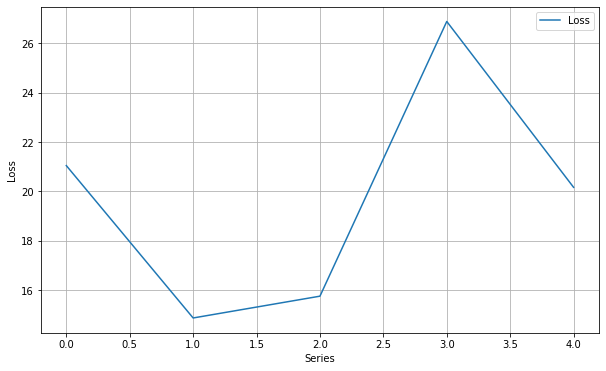

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="Loss")



plt.xlabel('Series')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
"""
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]


for i in range(X_test.size(0)):
  curent_X_test=X_test[i,:,:,:]
  current_y_test=y_test[i,:,:,:]
  pred=model(curent_X_test,current_y_test)
  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()

  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))
  ""
  plt.figure(figsize=(10, 6))
  plt.plot(current_y_test, label='Ground Truth')
  plt.plot(pred, label='Predicted')
  plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
"""

'\noutput=[]\nground_truth=[]\npred_series=[]\ntruth_series=[]\nloss=[]\npred_total=[]\ny_total=[]\n\n\nfor i in range(X_test.size(0)):\n  curent_X_test=X_test[i,:,:,:]\n  current_y_test=y_test[i,:,:,:]\n  pred=model(curent_X_test,current_y_test)\n  pred=pred[:,-horizon:,:]\n  pred=pred.reshape(-1,1).detach().numpy()\n  current_y_test=current_y_test.reshape(-1,1).detach().numpy()\n\n  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))\n  ""\n  plt.figure(figsize=(10, 6))\n  plt.plot(current_y_test, label=\'Ground Truth\')\n  plt.plot(pred, label=\'Predicted\')\n  plt.title(f\'Time Series {i+1}: Ground Truth vs Predicted Values\')\n  plt.xlabel(\'Time\')\n  plt.ylabel(\'Value\')\n  plt.legend()\n  plt.grid(True)\n'

In [62]:
loss

[tensor(21.0474),
 tensor(14.8732),
 tensor(15.7566),
 tensor(26.8873),
 tensor(20.1666)]

In [63]:
"""
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]
true_values=[]
predicted_values=[]

for i in range(X_test.size(0)):
  curent_X_test=X_test[i,:,:,:]
  current_y_test=y_test[i,:,:,:]
  pred=model(curent_X_test,current_y_test)
  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()


  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))
"""

'\noutput=[]\nground_truth=[]\npred_series=[]\ntruth_series=[]\nloss=[]\npred_total=[]\ny_total=[]\ntrue_values=[]\npredicted_values=[]\n\nfor i in range(X_test.size(0)):\n  curent_X_test=X_test[i,:,:,:]\n  current_y_test=y_test[i,:,:,:]\n  pred=model(curent_X_test,current_y_test)\n  pred=pred[:,-horizon:,:]\n  pred=pred.reshape(-1,1).detach().numpy()\n  current_y_test=current_y_test.reshape(-1,1).detach().numpy()\n\n\n  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))\n'